In [1]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

In [2]:
from point_configuration import PointConfiguration
N = 10; d = 3
pts = PointConfiguration(N, d)
pts.set_points('random')

## SRLS: Missing anchors

deleting indices: [7 6 8]


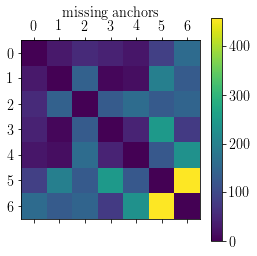

smallest eigenvalue is zero


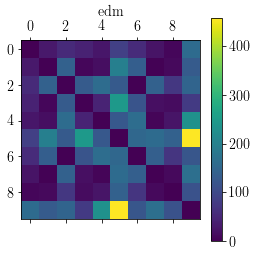

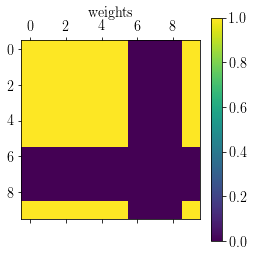

smallest eigenvalue is zero


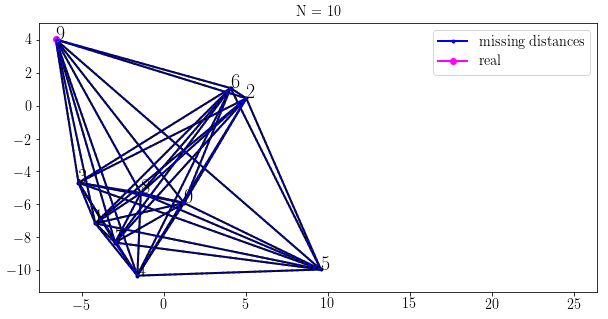

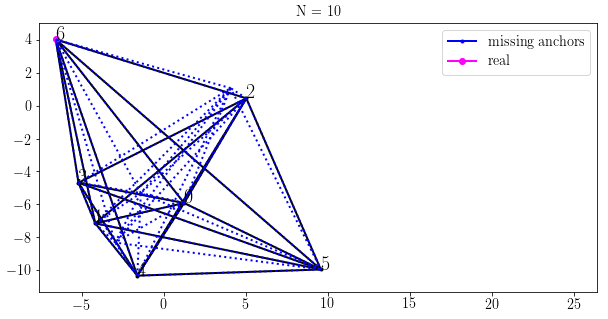

In [5]:
from basics import create_noisy_edm
from algorithms import reconstruct_srls
from point_configuration import create_from_points
from plots_cti import plot_matrix

index = -1
noise = 0.0

# Tests with zero noise
test = reconstruct_srls(pts.edm, pts.points, index=index)
assert np.linalg.norm(test - pts.points) < 1e-10
edm_test = create_noisy_edm(pts.edm, 0.0)
assert np.linalg.norm(edm_test - pts.edm) < 1e-10

other = np.delete(range(pts.N), index)
edm_noisy = create_noisy_edm(pts.edm, noise)

# missing anchors
N_missing = 3
indices = np.random.choice(other, size=N_missing, replace=False)
print('deleting indices:',indices)
reduced_points = np.delete(pts.points, indices, axis=0)
points_missing = create_from_points(reduced_points, PointConfiguration)
edm_missing = np.delete(edm_noisy, indices, axis=0)
edm_missing = np.delete(edm_missing, indices, axis=1)
plot_matrix(edm_missing,'missing anchors')
missing_anchors = reconstruct_srls(edm_missing, points_missing.points, index=index, weights=None)

# missing distances
weights = np.ones(edm_noisy.shape)
weights[indices, :] = 0.0
weights[:, indices] = 0.0

plot_matrix(edm_noisy,'edm')
plot_matrix(weights,'weights')
missing_distances = reconstruct_srls(edm_noisy, pts.points, index=index, weights=weights)
left_distances = np.delete(range(pts.N), indices)

assert np.linalg.norm(
    missing_distances[left_distances, :] - missing_anchors) < 1e-10, 'anchors moved.'
assert np.linalg.norm(
    missing_distances[index, :] - missing_anchors[index, :]) < 1e-10, 'point moved.'
assert np.linalg.norm(missing_distances - pts.points) < 1e-10

from plots_cti import plot_point_sets
plot_point_sets([missing_distances,pts.points],names=['missing distances','real'],display_lines=True)
plot_point_sets([missing_anchors,pts.points],names=['missing anchors','real'],display_lines=True)

## MDS with matrix completion

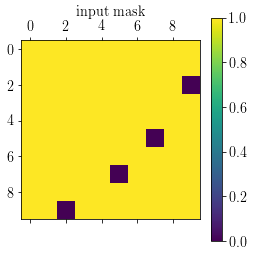

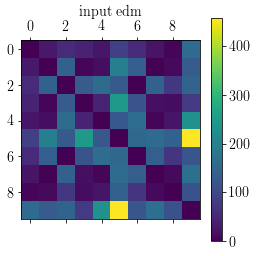

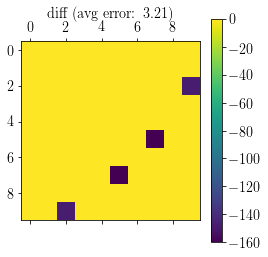

In [6]:
def create_symmetric_mask(N, p=0.7):
    mask = np.random.binomial(n=1,p=p,size=(N,N))
    mask[range(N), range(N)] = 1.0
    mask = np.bitwise_or(mask,mask.T)
    return mask

mask = create_symmetric_mask(N, p=0.7)
nnz = np.count_nonzero(mask)
plot_matrix(mask,'input mask')
plot_matrix(edm_noisy, 'input edm')
edm_mask = np.multiply(edm_noisy, mask)
plot_matrix(edm_mask-edm_noisy,'diff (avg error: {:2.2f})'.format(
    np.linalg.norm(edm_mask-edm_noisy)/nnz))

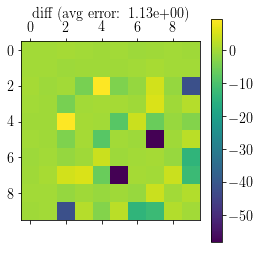

In [19]:
# Alternating Rank-based EDM Comletion
from algorithms import alternating_completion

edm_alt, dist = alternating_completion(edm_noisy, d+2, mask)
plot_matrix(edm_alt-edm_noisy,'diff (avg error: {:2.2e})'.format(
    np.linalg.norm(edm_alt-edm_noisy)/nnz))

rank 5


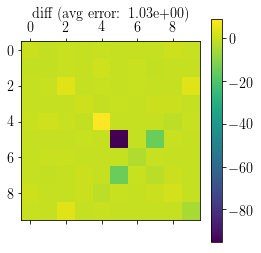

In [18]:
## OptSpace
from opt_space import opt_space

X, S, Y, dist = opt_space(edm_mask, r=d+2, niter=500, tol=1e-6, print_out=False)
edm_opt = X.dot(S.dot(Y.T))
print('rank',np.linalg.matrix_rank(edm_opt))
edm_hat[range(N), range(N)] = 0.0
plot_matrix(edm_opt-edm_noisy,'diff (avg error: {:2.2e})'.format(
    np.linalg.norm(edm_opt-edm_noisy)/nnz))

total cost: 452.7738067606615
trace of H: 453.792092048
other cost: 10.8806142213


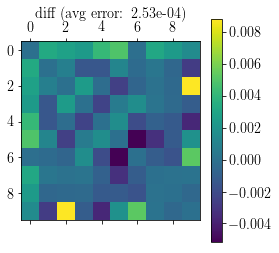

In [17]:
## SDP
from semidefinite import reconstruct_sdp
lamda = 1000
Xhat, edm_sdp = reconstruct_sdp(edm_noisy, mask, lamda, pts.points)
plot_matrix(edm_sdp-edm_noisy,'diff (avg error: {:2.2e})'.format(
    np.linalg.norm(edm_sdp-edm_noisy)/nnz))

converged after 2


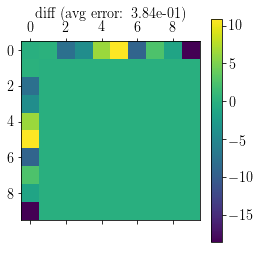

In [27]:
## dwMDS
from basics import get_edm
from distributed_mds import reconstruct_dwmds

# TODO: make this work for m = 0 (n = N)
Xhat, __ = reconstruct_dwmds(edm_noisy, pts.points, mask, n=1) 
edm_dw = get_edm(Xhat)
plot_matrix(edm_dw-edm_noisy,'diff (avg error: {:2.2e})'.format(
    np.linalg.norm(edm_dw-edm_noisy)/nnz))